# Dataset Loading

In [1]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root = 'split_dataset'
splits = ['train','val','test']
classes = ['ford_escape','ford_explorer','honda_civic','honda_odyssey',
           'mitsubishi_lancer','mitsubishi_outlander','nissan_altima','nissan_maxima']

# Extracting SIFT Descriptors

In [3]:
sift = cv2.SIFT_create()

def extract_descriptors(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = sift.detectAndCompute(gray, None)
    return desc  # desc.shape = (num_keypoints, 128)

In [4]:
all_desc = []
for cls in classes:
    cls_dir = os.path.join(root,'train',cls)
    for fname in os.listdir(cls_dir):
        path = os.path.join(cls_dir,fname)
        d = extract_descriptors(path)
        if d is not None:
            all_desc.append(d)
all_desc = np.vstack(all_desc)  # shape = (total_descriptors, 128)

# Building the Visual Vocabulary (BoVW)

In [5]:
K = 100  # vocabulary size
kmeans = KMeans(n_clusters=K, random_state=42).fit(all_desc)
vocab = kmeans.cluster_centers_

# Encoding Images as Histograms

In [6]:
def compute_bovw_histogram(desc, kmeans):
    if desc is None:
        return np.zeros(K)
    words = kmeans.predict(desc)
    hist, _ = np.histogram(words, bins=np.arange(K+1))
    return hist

def image_to_feature(image_path, kmeans):
    desc = extract_descriptors(image_path)
    hist = compute_bovw_histogram(desc, kmeans)
    return hist

In [7]:
def build_dataset(split):
    X, y = [], []
    for idx, cls in enumerate(classes):
        cls_dir = os.path.join(root, split, cls)
        for fname in os.listdir(cls_dir):
            path = os.path.join(cls_dir, fname)
            X.append(image_to_feature(path, kmeans))
            y.append(idx)
    return np.array(X), np.array(y)

X_train, y_train = build_dataset('train')
X_val,   y_val   = build_dataset('val')
X_test,  y_test  = build_dataset('test')

# Training and Evaluation

## Feature Scaling

In [8]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

## Train SVM

In [9]:
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train_s, y_train)

SVC(C=10, random_state=42)

## Evaluate

In [10]:
for split, X_s, y in [('Train',X_train_s,y_train),
                     ('Val',X_val_s,y_val),
                     ('Test',X_test_s,y_test)]:
    preds = svm.predict(X_s)
    print(f'=== {split} Accuracy:', accuracy_score(y, preds))
    print(classification_report(y, preds, target_names=classes))

=== Train Accuracy: 0.9065281899109793
                      precision    recall  f1-score   support

         ford_escape       0.94      0.90      0.92       332
       ford_explorer       0.94      0.93      0.93       569
         honda_civic       0.83      0.95      0.89       736
       honda_odyssey       0.95      0.90      0.92       455
   mitsubishi_lancer       1.00      0.76      0.86       124
mitsubishi_outlander       1.00      0.93      0.96        44
       nissan_altima       0.88      0.93      0.90       718
       nissan_maxima       0.98      0.80      0.88       392

            accuracy                           0.91      3370
           macro avg       0.94      0.89      0.91      3370
        weighted avg       0.91      0.91      0.91      3370

=== Val Accuracy: 0.2966507177033493
                      precision    recall  f1-score   support

         ford_escape       0.28      0.27      0.28        41
       ford_explorer       0.29      0.28      0.29 

In [11]:
# 1. Generate predictions for each split
pred_train = svm.predict(X_train_s)
pred_val   = svm.predict(X_val_s)
pred_test  = svm.predict(X_test_s)

# 2. Compute confusion matrices
cm_train = confusion_matrix(y_train, pred_train)
cm_val   = confusion_matrix(y_val,   pred_val)
cm_test  = confusion_matrix(y_test,  pred_test)

# 3. Plot & save function
def plot_and_save_cm(cm, title, class_labels):
    plt.figure()
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=class_labels, 
        yticklabels=class_labels
    )
    plt.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ticks = range(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45, ha='right')
    plt.yticks(ticks, class_labels)
    plt.tight_layout()
    filename = title.lower().replace(' ', '_') + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✔ Saved confusion matrix as {filename}")

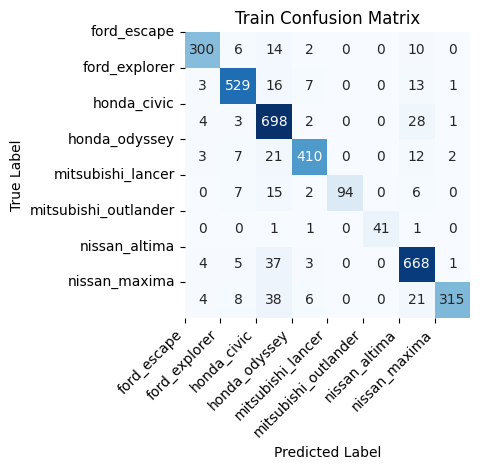

✔ Saved confusion matrix as train_confusion_matrix.png


In [12]:
# Call for each split
plot_and_save_cm(cm_train, "Train Confusion Matrix", classes)

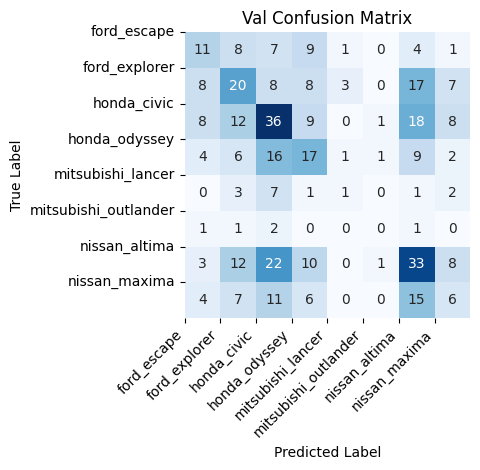

✔ Saved confusion matrix as val_confusion_matrix.png


In [13]:
plot_and_save_cm(cm_val,   "Val Confusion Matrix",   classes)

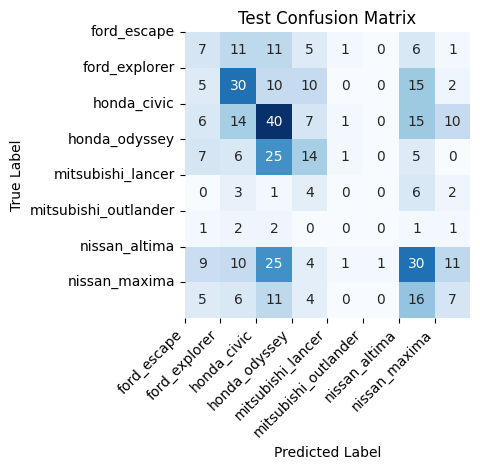

✔ Saved confusion matrix as test_confusion_matrix.png


In [14]:
plot_and_save_cm(cm_test,  "Test Confusion Matrix",  classes)